In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9704 entries, 0 to 9703
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   engine_displacement  9704 non-null   int64  
 1   num_cylinders        9222 non-null   float64
 2   horsepower           8996 non-null   float64
 3   vehicle_weight       9704 non-null   float64
 4   acceleration         8774 non-null   float64
 5   model_year           9704 non-null   int64  
 6   origin               9704 non-null   object 
 7   fuel_type            9704 non-null   object 
 8   drivetrain           9704 non-null   object 
 9   num_doors            9202 non-null   float64
 10  fuel_efficiency_mpg  9704 non-null   float64
dtypes: float64(6), int64(2), object(3)
memory usage: 834.1+ KB


In [14]:
# Inspect objects
object_cols = df.select_dtypes(include=['object']).columns.to_list()
object_cols
for col in object_cols:
    print(f'{col}: {df[col].unique()}')

origin: ['Europe' 'USA' 'Asia']
fuel_type: ['Gasoline' 'Diesel']
drivetrain: ['All-wheel drive' 'Front-wheel drive']


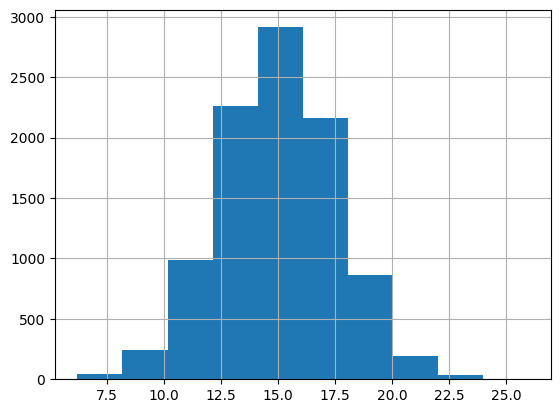

In [ ]:
# EDA
# Look at the fuel_efficiency_mpg variable. Does it have a long tail?
df.fuel_efficiency_mpg.hist();

# Answer: no!

In [17]:
# Q1: There's one column with missing values. What is it?
# Answer: horsepower

In [18]:
# Q2: What's the median (50% percentile) for variable 'horsepower'?
df.horsepower.median()

np.float64(149.0)

In [19]:
# Prepare and split dataset
FEATURES = ['engine_displacement','horsepower','vehicle_weight','model_year']
TARGET = ['fuel_efficiency_mpg']
SEED = 42

X = df[FEATURES]
y = df[TARGET]

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=SEED, shuffle=True)

In [25]:
# Q3: fill missing values with either 0 or mean, find RMSE
imputer_zero = SimpleImputer(strategy='constant', fill_value=0)
imputer_mean = SimpleImputer(strategy='mean')
scaler = RobustScaler()
model = LinearRegression()

pipe_zero = Pipeline(steps=[
    ('impute', imputer_zero),
    ('scale', scaler),
    ('model', model)
])

pipe_mean = Pipeline(steps=[
    ('impute', imputer_mean),
    ('scale', scaler),
    ('model', model)
])

pipe_zero.fit(X_train, y_train)
y_pred_zero = pipe_zero.predict(X_val)
rmse_zero = root_mean_squared_error(y_val, y_pred_zero)

pipe_mean.fit(X_train, y_train)
y_pred_mean = pipe_mean.predict(X_val)
rmse_mean = root_mean_squared_error(y_val, y_pred_mean)

print(f'RMSE zero: {rmse_zero}')
print(f'RMSE mean: {rmse_mean}')

RMSE zero: 0.5106669529760013
RMSE mean: 0.45989701757218504


In [44]:
# Q4: 
# Now let's train a regularized linear regression.
# For this question, fill the NAs with 0.
# Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
# Use RMSE to evaluate the model on the validation dataset.
# Round the RMSE scores to 2 decimal digits.
# Which r gives the best RMSE?

model = Lasso()
pipe = Pipeline(steps=[
    ('impute', imputer_zero),
    ('scale', scaler),
    ('model', model)
    ])

r_vals = [0, 0.01, 0.1, 1, 5, 10, 100]
rmses = {}
for r in r_vals:
    pipe.set_params(model=Lasso(alpha=r))
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    rmses[r] = rmse

print(rmses)
print(min(rmses, key=rmses.get))

{0: 0.507244093979345, 0.01: 0.5074111460459366, 0.1: 0.5302183810403809, 1: 1.4276541015883741, 5: 2.5098025668095665, 10: 2.5098025668095665, 100: 2.5098025668095665}
0


/Users/gamec/workspace/github.com/tylerlaubach/zoomcamp-ml/.venv/lib/python3.13/site-packages/sklearn/base.py:1365: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Users/gamec/workspace/github.com/tylerlaubach/zoomcamp-ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Users/gamec/workspace/github.com/tylerlaubach/zoomcamp-ml/.venv/lib/python3.13/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.043e+03, tolerance: 5.078e+00
Linear regression models with a zero l1 penalization strength ar

In [41]:
# Q5:
# We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
# Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
# For each seed, do the train/validation/test split with 60%/20%/20% distribution.
# Fill the missing values with 0 and train a model without regularization.
# For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
# What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
# Round the result to 3 decimal digits (round(std, 3))
# What's the value of std?

model = LinearRegression()
pipe = Pipeline(steps=[
    ('impute', imputer_zero),
    ('scale', scaler),
    ('model', model)
    ])

seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rmses = {}
for seed in seeds:
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, shuffle=True)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=seed, shuffle=True)
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_val)
    rmse = root_mean_squared_error(y_val, y_pred)
    rmses[seed] = rmse

print(round(np.std(list(rmses.values())), 3))
    

0.007


In [42]:
# Q6:
# Split the dataset like previously, use seed 9.
# Combine train and validation datasets.
# Fill the missing values with 0 and train a model with r=0.001.
# What's the RMSE on the test dataset?

SEED = 9
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, shuffle=True)
model = Lasso(alpha=0.001)
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
rmse = root_mean_squared_error(y_test, y_pred)
print(rmse)

0.5210335981917606
